### Libraries and Data Loading

In [1]:
# pip install pandasql

In [2]:
# pip install pandasql --upgrade


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore") # ignoring annoying warnings

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [4]:
features = pd.read_csv('D:\Decion Making\data\Features data set.csv')
train = pd.read_csv('D:\Decion Making\data\Train.csv')
stores = pd.read_csv('data\stores data-set.csv')
test = pd.read_csv('D:\Decion Making\data\Test.csv')
sample_submission = pd.read_csv('D:\Decion Making\data\sampleSubmission.csv')

### Exploratory Analysis and Data Cleaning

In [5]:
feat_sto = features.merge(stores, how='inner', on='Store')

In [6]:
feat_sto.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [7]:
pd.DataFrame(feat_sto.dtypes, columns=['Type'])

,Type
Store,int64
Date,object
Temperature,float64
Fuel_Price,float64
MarkDown1,float64
MarkDown2,float64
MarkDown3,float64
MarkDown4,float64
MarkDown5,float64
CPI,float64


In [8]:
train.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [9]:
pd.DataFrame({'Type_Train': train.dtypes, 'Type_Test': test.dtypes})

,Type_Train,Type_Test
Date,object,object
Dept,int64,int64
IsHoliday,bool,bool
Store,int64,int64
Weekly_Sales,float64,NaN


In [10]:
feat_sto.Date = pd.to_datetime(feat_sto.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

In [11]:
feat_sto['Week'] = feat_sto.Date.dt.week 
feat_sto['Year'] = feat_sto.Date.dt.year

In [12]:
train_detail = train.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [13]:
test_detail = test.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [14]:
del features, train, stores, test

Search for null values for each column.

In [15]:
null_columns = (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False).index
null_data = pd.concat([
    train_detail.isnull().sum(axis = 0),
    (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False),
    train_detail.loc[:, train_detail.columns.isin(list(null_columns))].dtypes], axis=1)
null_data = null_data.rename(columns={0: '# null', 
                                      1: '% null', 
                                      2: 'type'}).sort_values(ascending=False, by = '% null')
null_data = null_data[null_data["# null"]!=0]
null_data

,# null,% null,type
MarkDown2,194590,0.687636,float64
MarkDown3,186429,0.658797,float64
MarkDown4,185441,0.655306,float64
MarkDown1,173625,0.613551,float64
MarkDown5,173219,0.612116,float64


> This step is important. There are some columns with more than 60% of null values. These features aren't correlated to the target feature "WeeklySales".We can remove them.


### Holidays Analysis

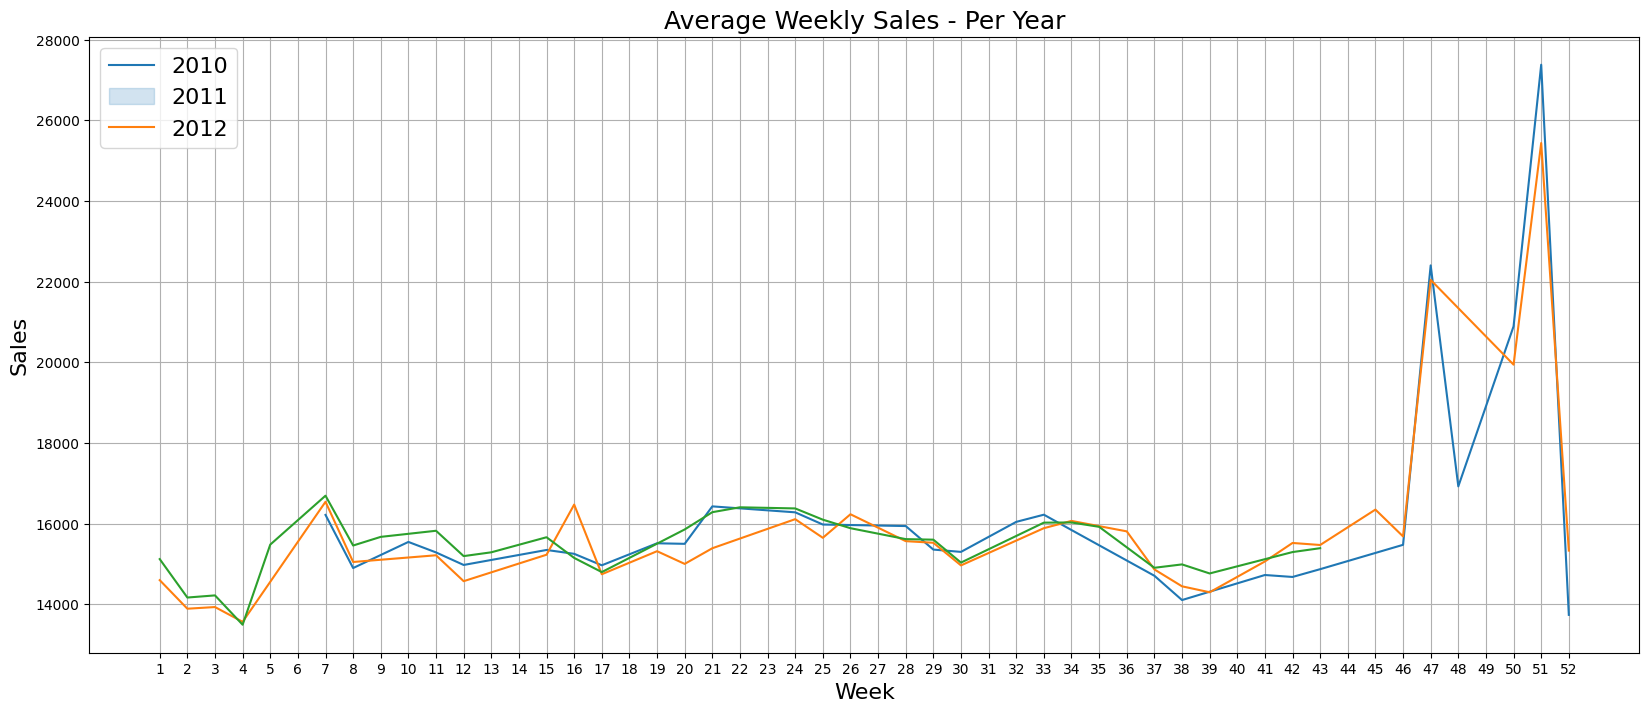

In [16]:
weekly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(x=weekly_sales_2010.index, y= weekly_sales_2010.values)
sns.lineplot(x=weekly_sales_2011.index, y= weekly_sales_2011.values)
sns.lineplot(x=weekly_sales_2012.index, y= weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

> As we can see, there is one important Holiday not included in 'IsHoliday'. It's the Easter Day. It is always in a Sunday, but can fall on different weeks. 
    >* In 2010 is in Week 13
    >* In 2011, Week 16
    >* Week 14 in 2012
    >* and, finally, Week 13 in 2013 for Test set

> So, we can change to 'True' these Weeks in each Year.

In [17]:
train_detail.loc[(train_detail.Year==2010) & (train_detail.Week==13), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2011) & (train_detail.Week==16), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2012) & (train_detail.Week==14), 'IsHoliday'] = True
test_detail.loc[(test_detail.Year==2013) & (test_detail.Week==13), 'IsHoliday'] = True

> The same chart, but showing also the median of the Sales and not divided by Year:

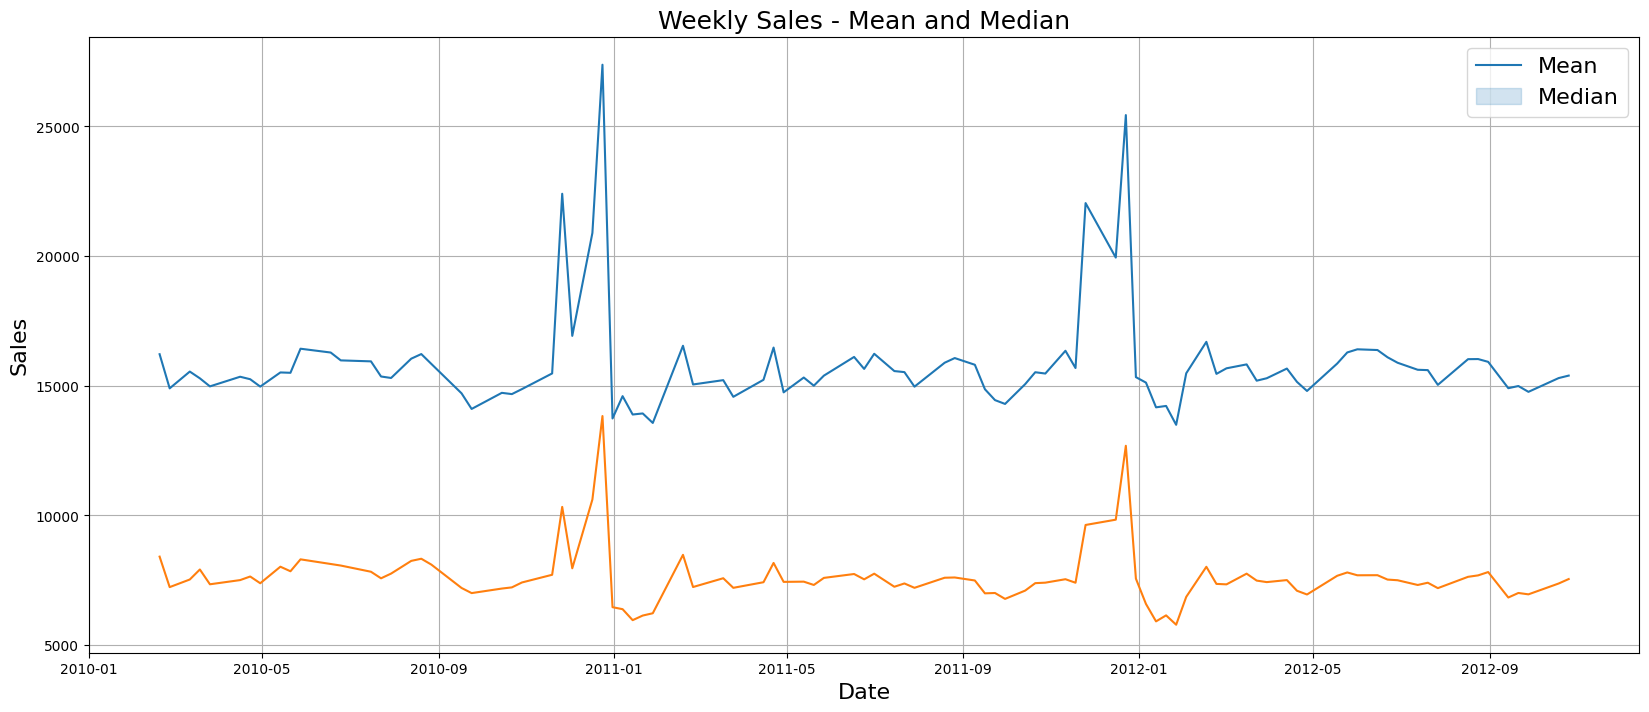

In [18]:
weekly_sales_mean = train_detail['Weekly_Sales'].groupby(train_detail['Date']).mean()
weekly_sales_median = train_detail['Weekly_Sales'].groupby(train_detail['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(x=weekly_sales_mean.index, y=weekly_sales_mean.values)
sns.lineplot(x=weekly_sales_median.index, y=weekly_sales_median.values)
plt.grid()
plt.legend(['Mean', 'Median'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean and Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

> Just as an observation, the mean and the median are very different, suggesting that some stores/departments might sell much more than others.

### Average Sales per Store and Department

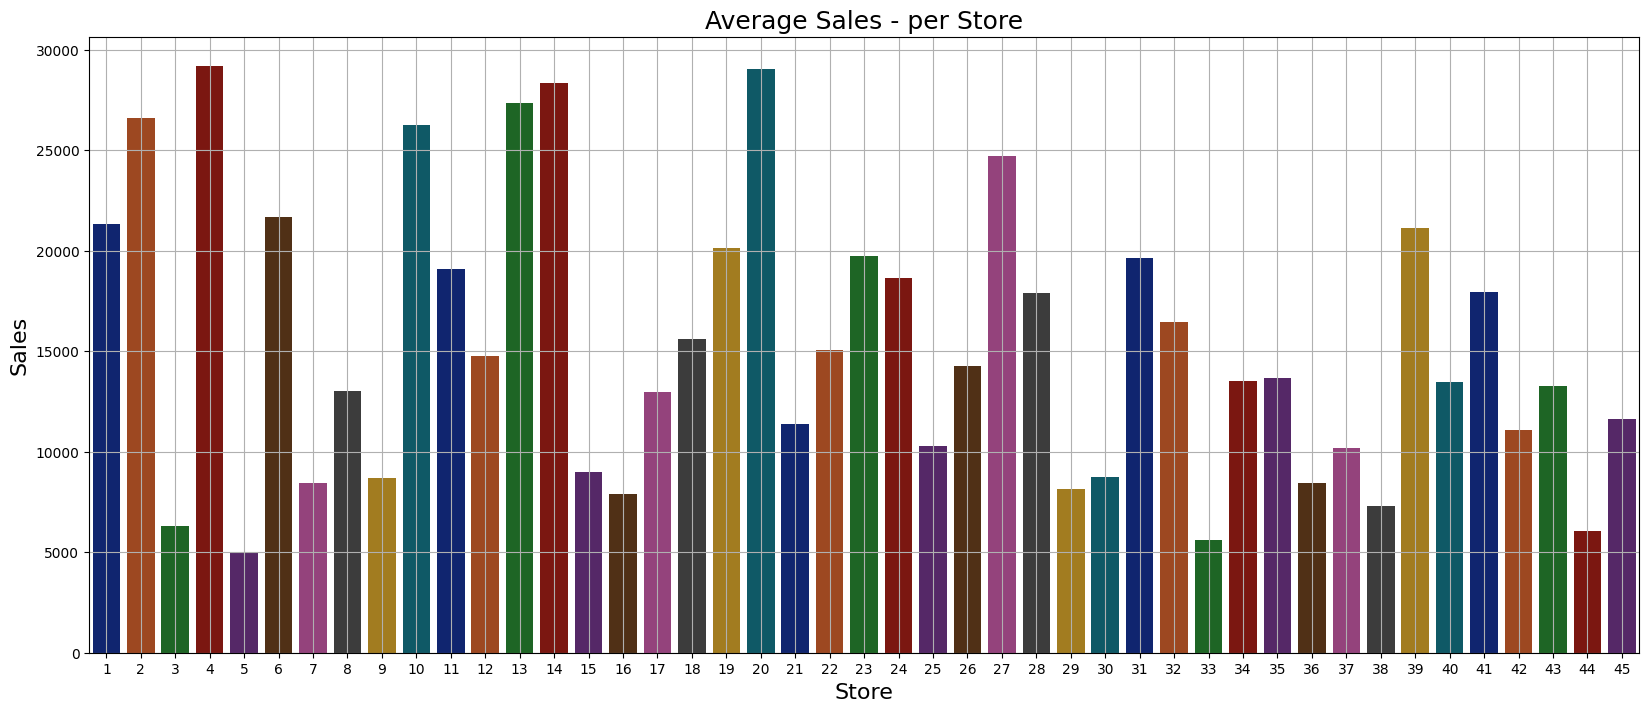

In [19]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(x=weekly_sales.index, y=weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

> There are Sales difference between the Stores.

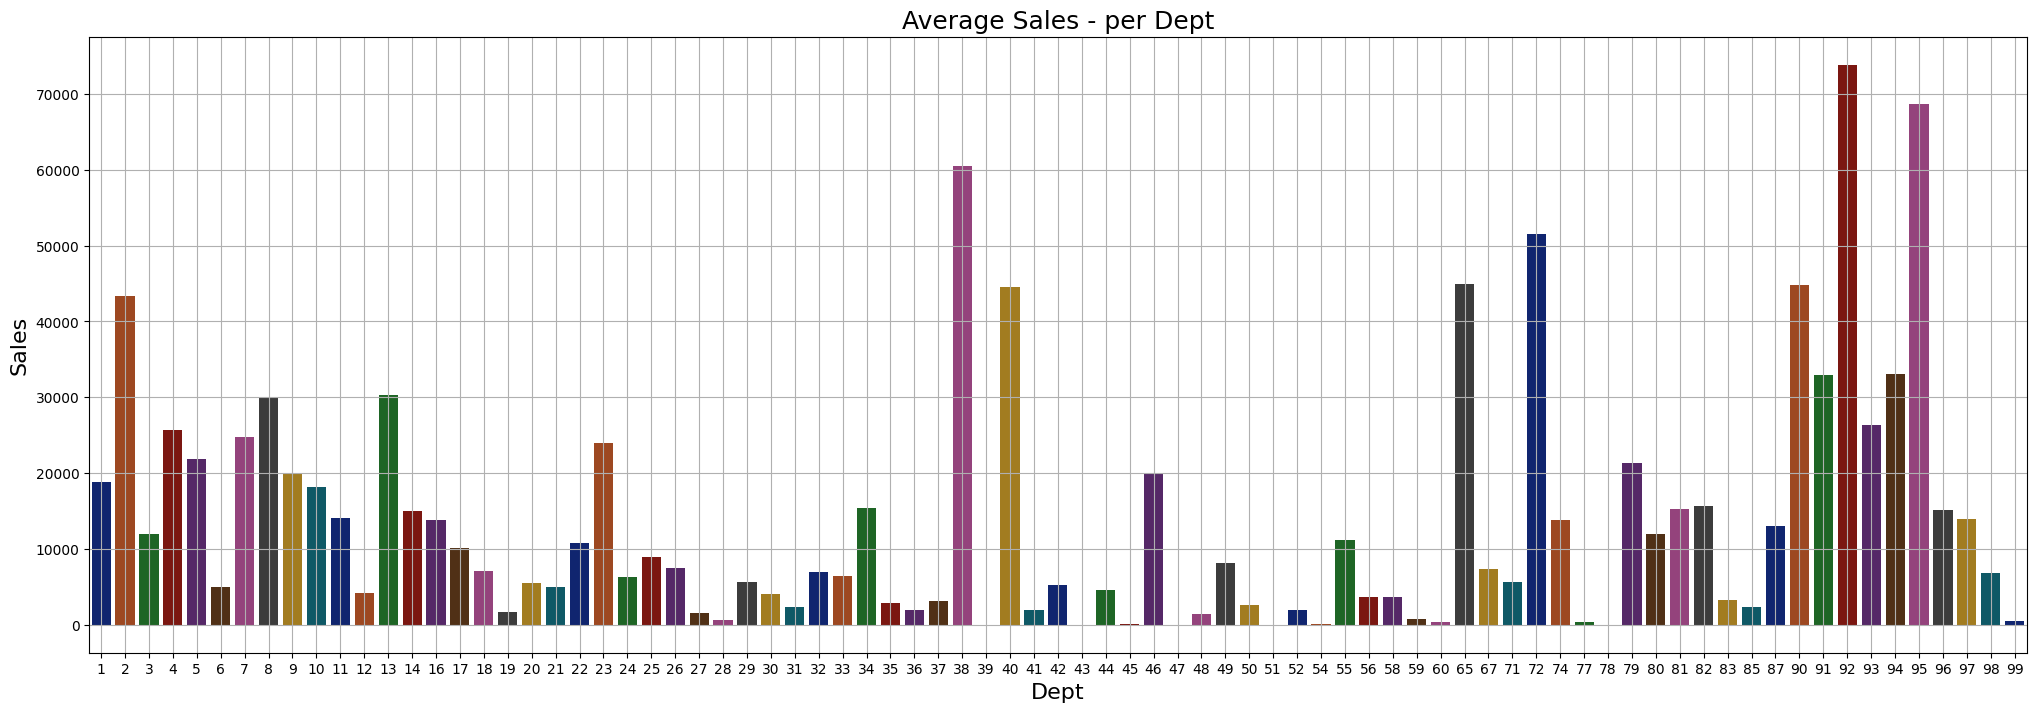

In [20]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()
plt.figure(figsize=(25,8))
sns.barplot(x=weekly_sales.index, y=weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

> And there are Sales difference between the Departments too. Also some Depts are not in the list, like number '15', for example.

### Variables Correlation

Let's see the correlation between variables, using Pearson Correlation.

> Correlation Metrics:
    >* 0: no correlation at all
    >* 0-0.3: weak correlation 
    >* 0.3-0.7: moderate correlaton
    >* 0.7-1: strong correlation

> Positive Correlation indicates that when one variable increase, the other also does. Negative is the opposite.

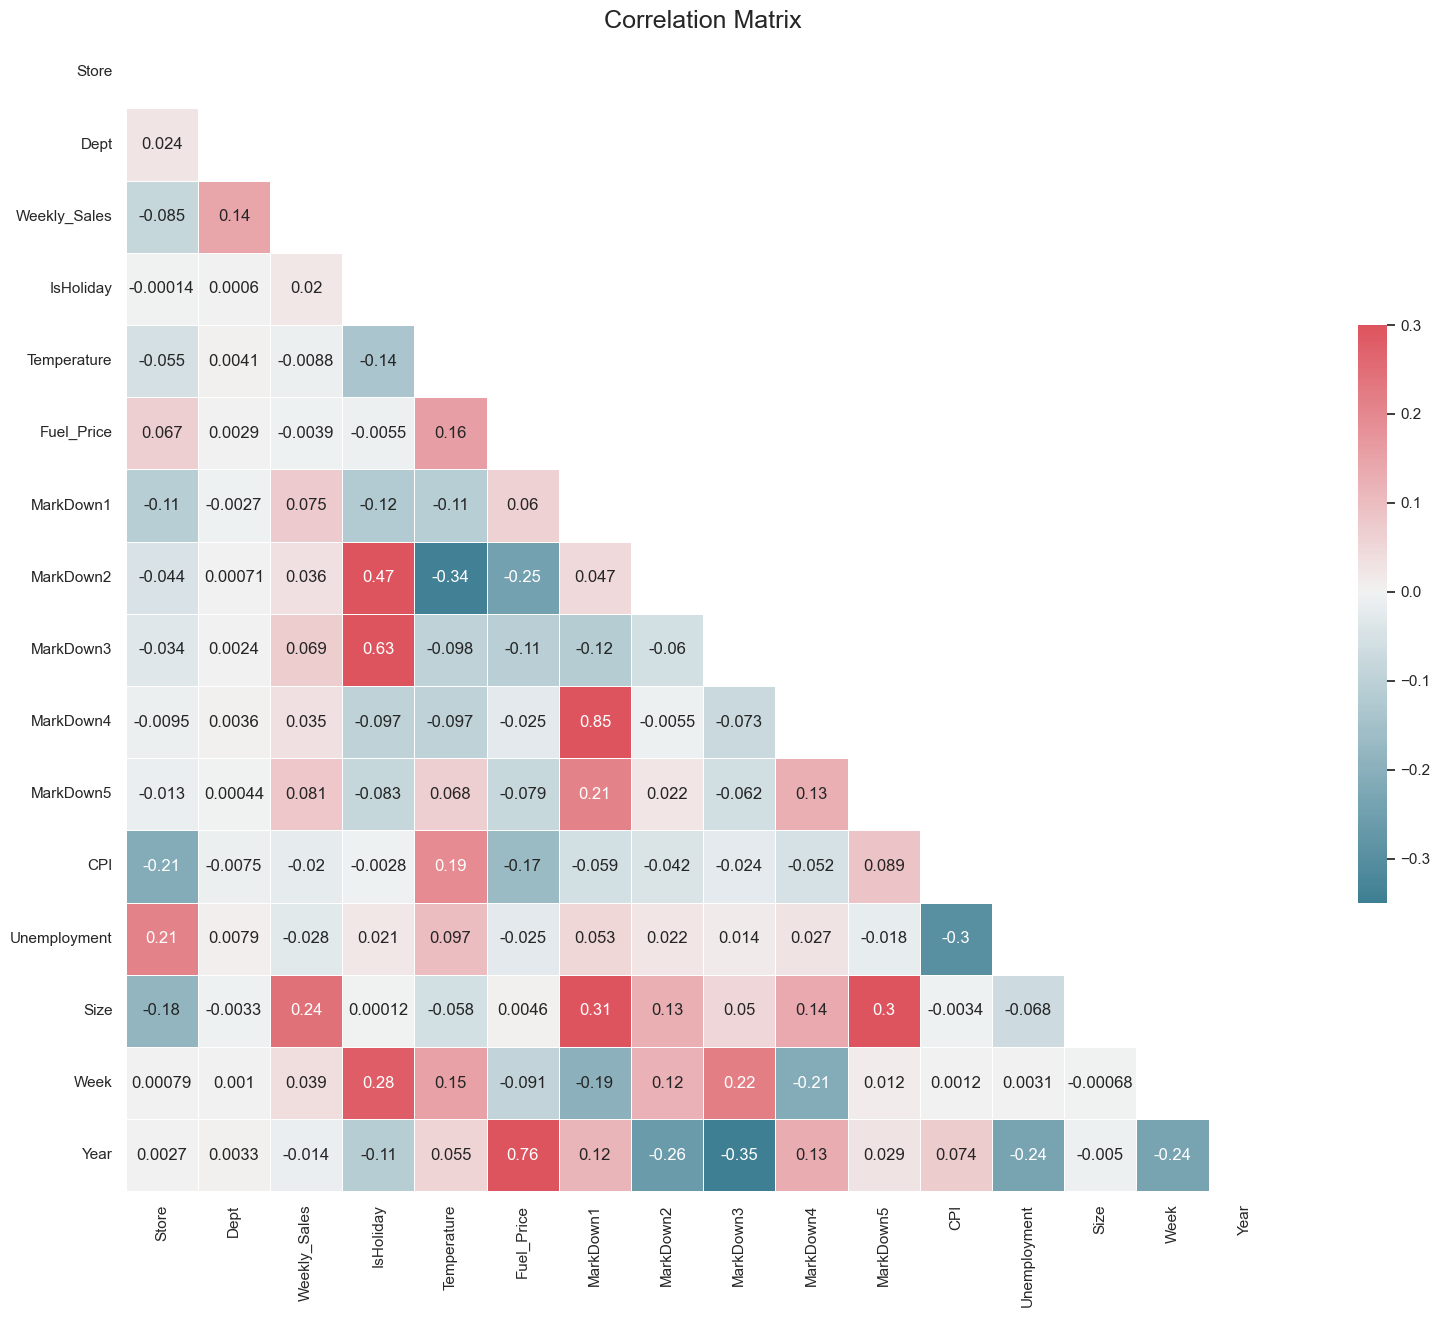

In [21]:
sns.set(style="white")

corr = train_detail.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

> 'MarkDown' 1 to 5 are not strong correlated to 'Weekly_Sales' and they have a lot of null values, then we can drop them.

> Also, 'Fuel_Price' is strong correlated to 'Year'. One of them must be dropped else they would carry similar information to the model. 'Year' will not be dropped, because it differentiate same Weeks for 'Store'+'Dept'.

> Other variables that have weak correlation with 'Weekly_Sales' can be analyzed to see if they are useful.

In [22]:
train_detail = train_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
test_detail = test_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

### Analyzing Variables

> First, two plot functions that will help us.

> The discrete plot is for finite numbers. We will use boxplot, to see the medians and interquartile ranges, and the striplot, which is a better way of seeing the distribution, even more when lots of outliers are present.

> The continuous plot, as the name says, is for continuous variables. We will see the distribution of probabilities and use BoxCox to understand if there is increase of correlation and decrease of skewness for each variable. In some cases the process of transforming a variable can help, depending on the model.

In [23]:
def make_discrete_plot(feature):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,0]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    sns.stripplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,1]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    fig.show()

In [24]:
def make_continuous_plot(feature):
    
    fig = plt.figure(figsize=(18,15))
    gs = GridSpec(2,2)
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.15), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

    plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.15)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.15), nan_policy='omit'),2)))
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.25), ax=fig.add_subplot(gs[1,0]), palette = 'blue')

    plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.25)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.25), nan_policy='omit'),2)))
    
    j = sns.distplot(train_detail[feature], ax=fig.add_subplot(gs[1,1]), color = 'green')

    plt.title('Distribution\n')
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=train_detail[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(train_detail[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(train_detail[feature], nan_policy='omit'),2)))
    
    fig.show()

### Weekly_Sales x IsHoliday

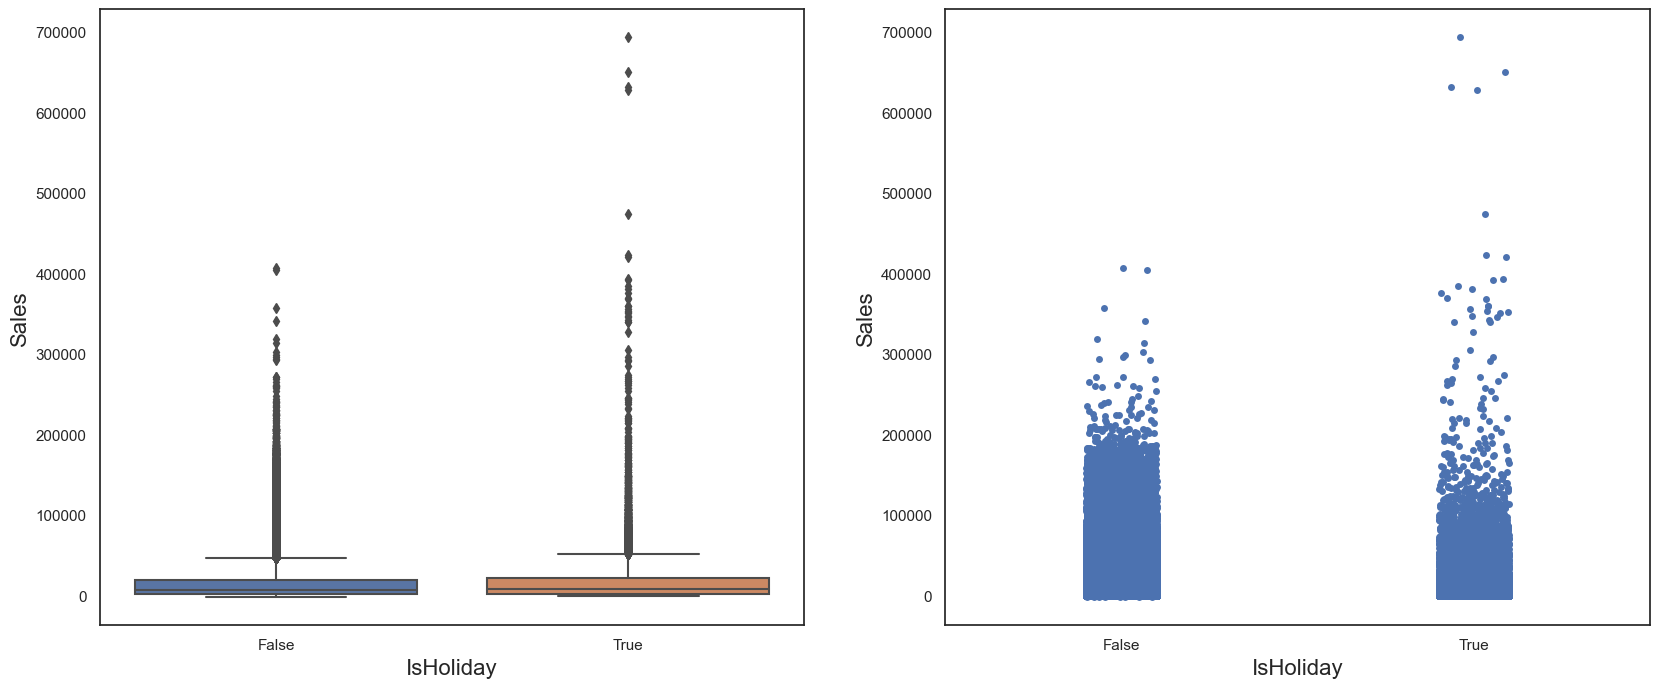

In [25]:
make_discrete_plot('IsHoliday')

> This field is going to be important to differentiate Week Holidays. As we can see, Week Holidays have more high sales events than non-Holiday Weeks.

### Weekly_Sales x Type

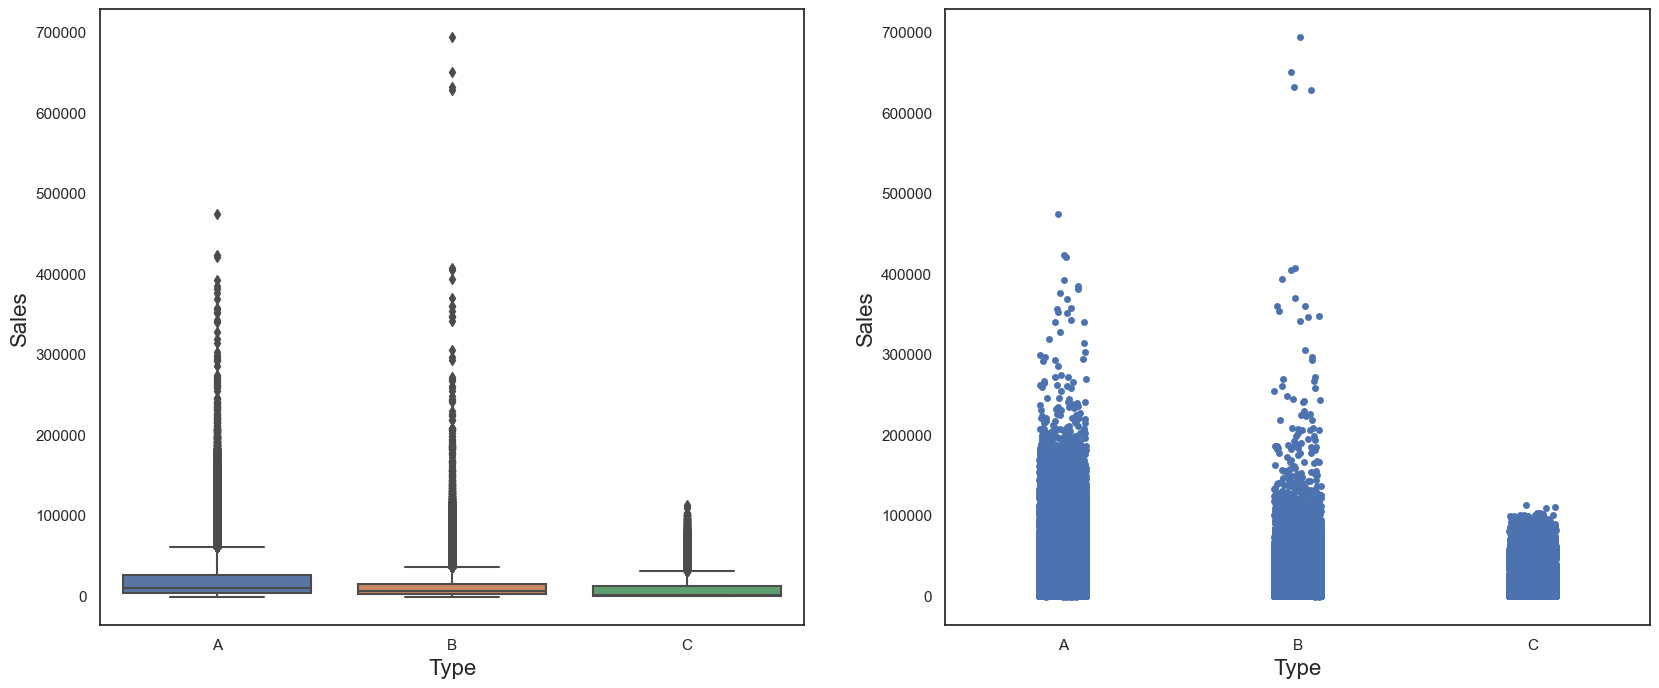

In [26]:
make_discrete_plot('Type')

> We don't know what 'Type' is, but we can assume that A > B > C in terms of Sales Median. So, let's treat it as an ordinal variable and replace its values. 

> Ordinal variables are explained in the figure below.

In [27]:
train_detail.Type = train_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
test_detail.Type = test_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))

### Weekly_Sales x Temperature

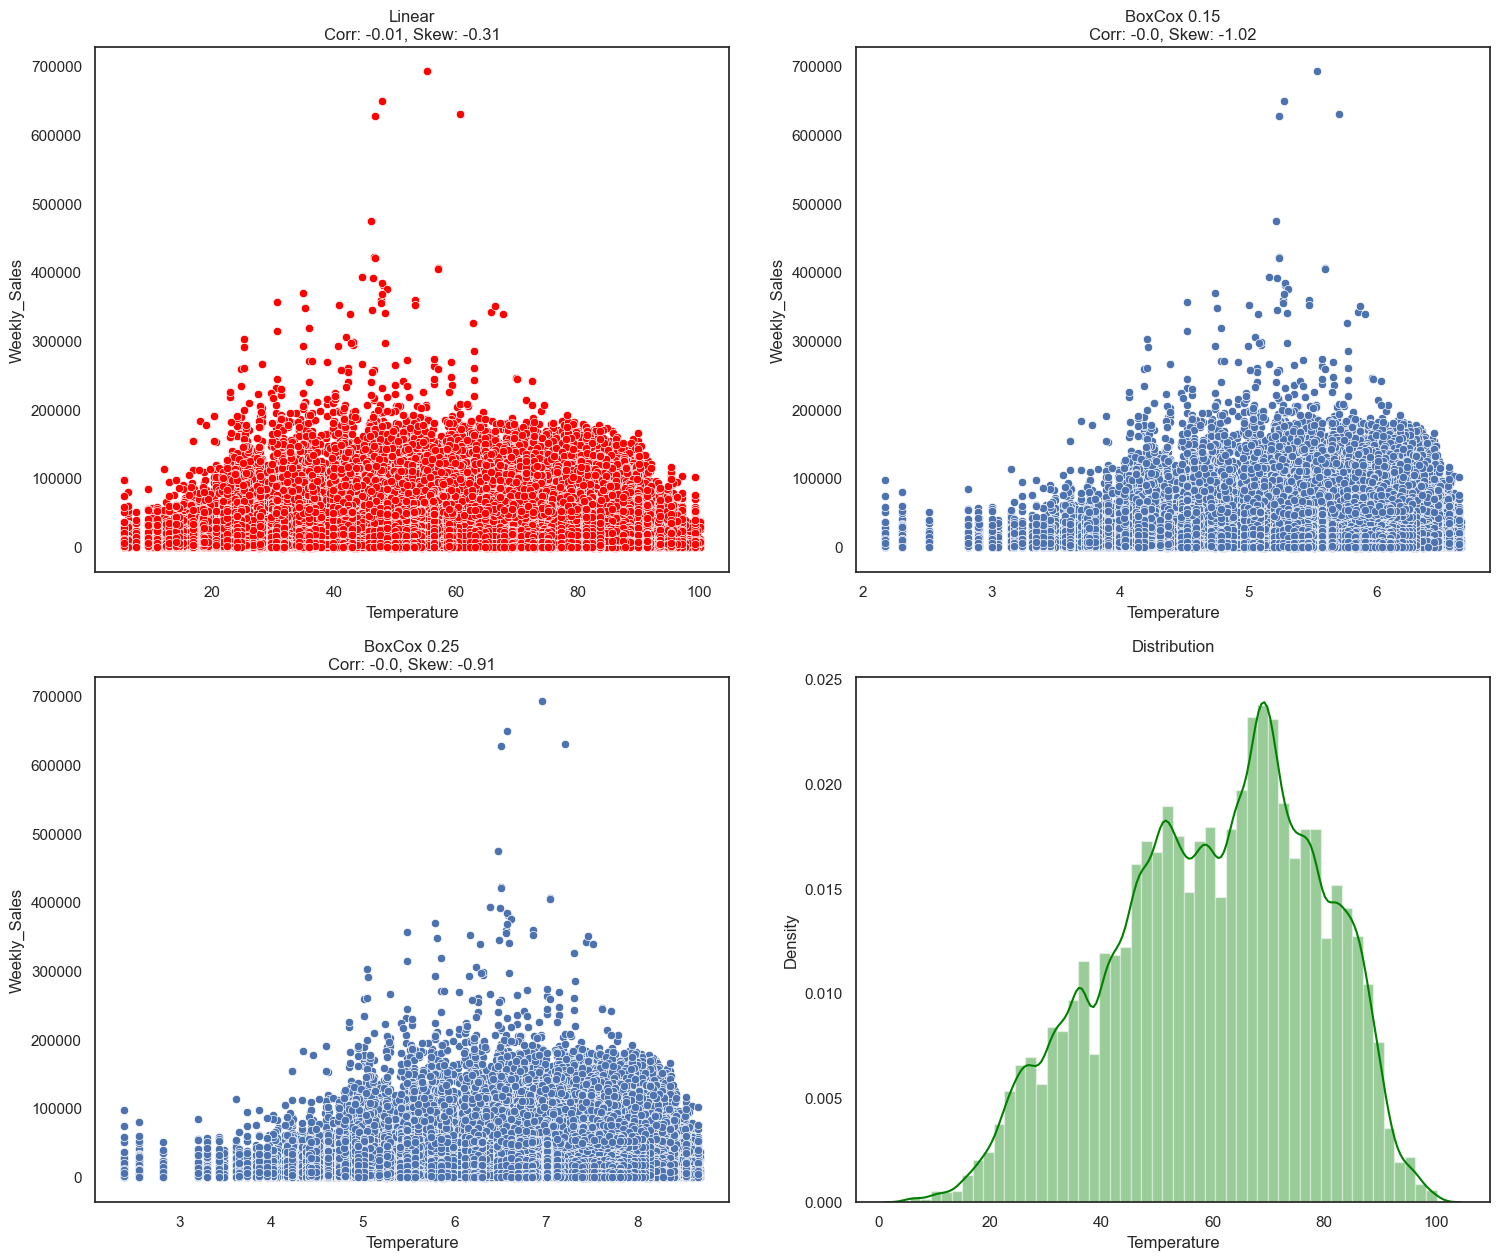

In [28]:
make_continuous_plot('Temperature')

> Although skewness changes, correlation doesn't seem to change at all. We can decide to drop it.

In [29]:
train_detail = train_detail.drop(columns=['Temperature'])
test_detail = test_detail.drop(columns=['Temperature'])

### Weekly_Sales x CPI

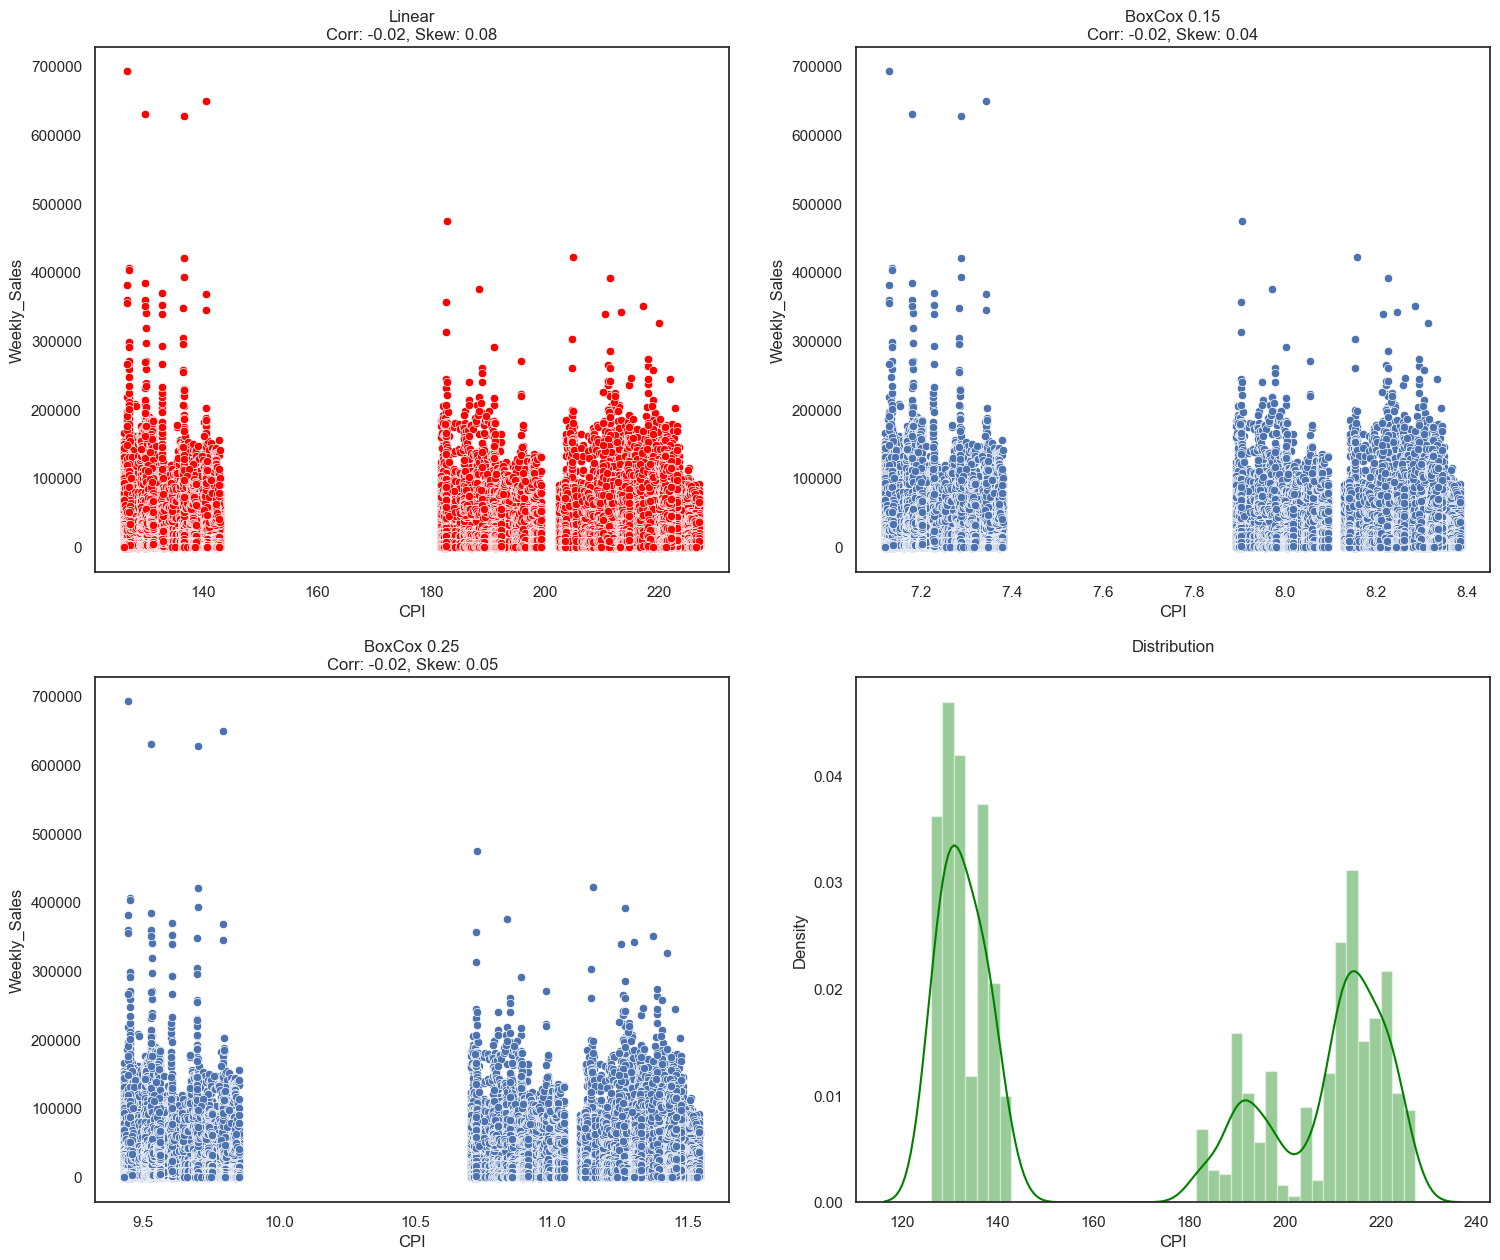

In [30]:
make_continuous_plot('CPI')

> Same for 'CPI'.

In [31]:
train_detail = train_detail.drop(columns=['CPI'])
test_detail = test_detail.drop(columns=['CPI'])

### Weekly_Sales x Unemployment

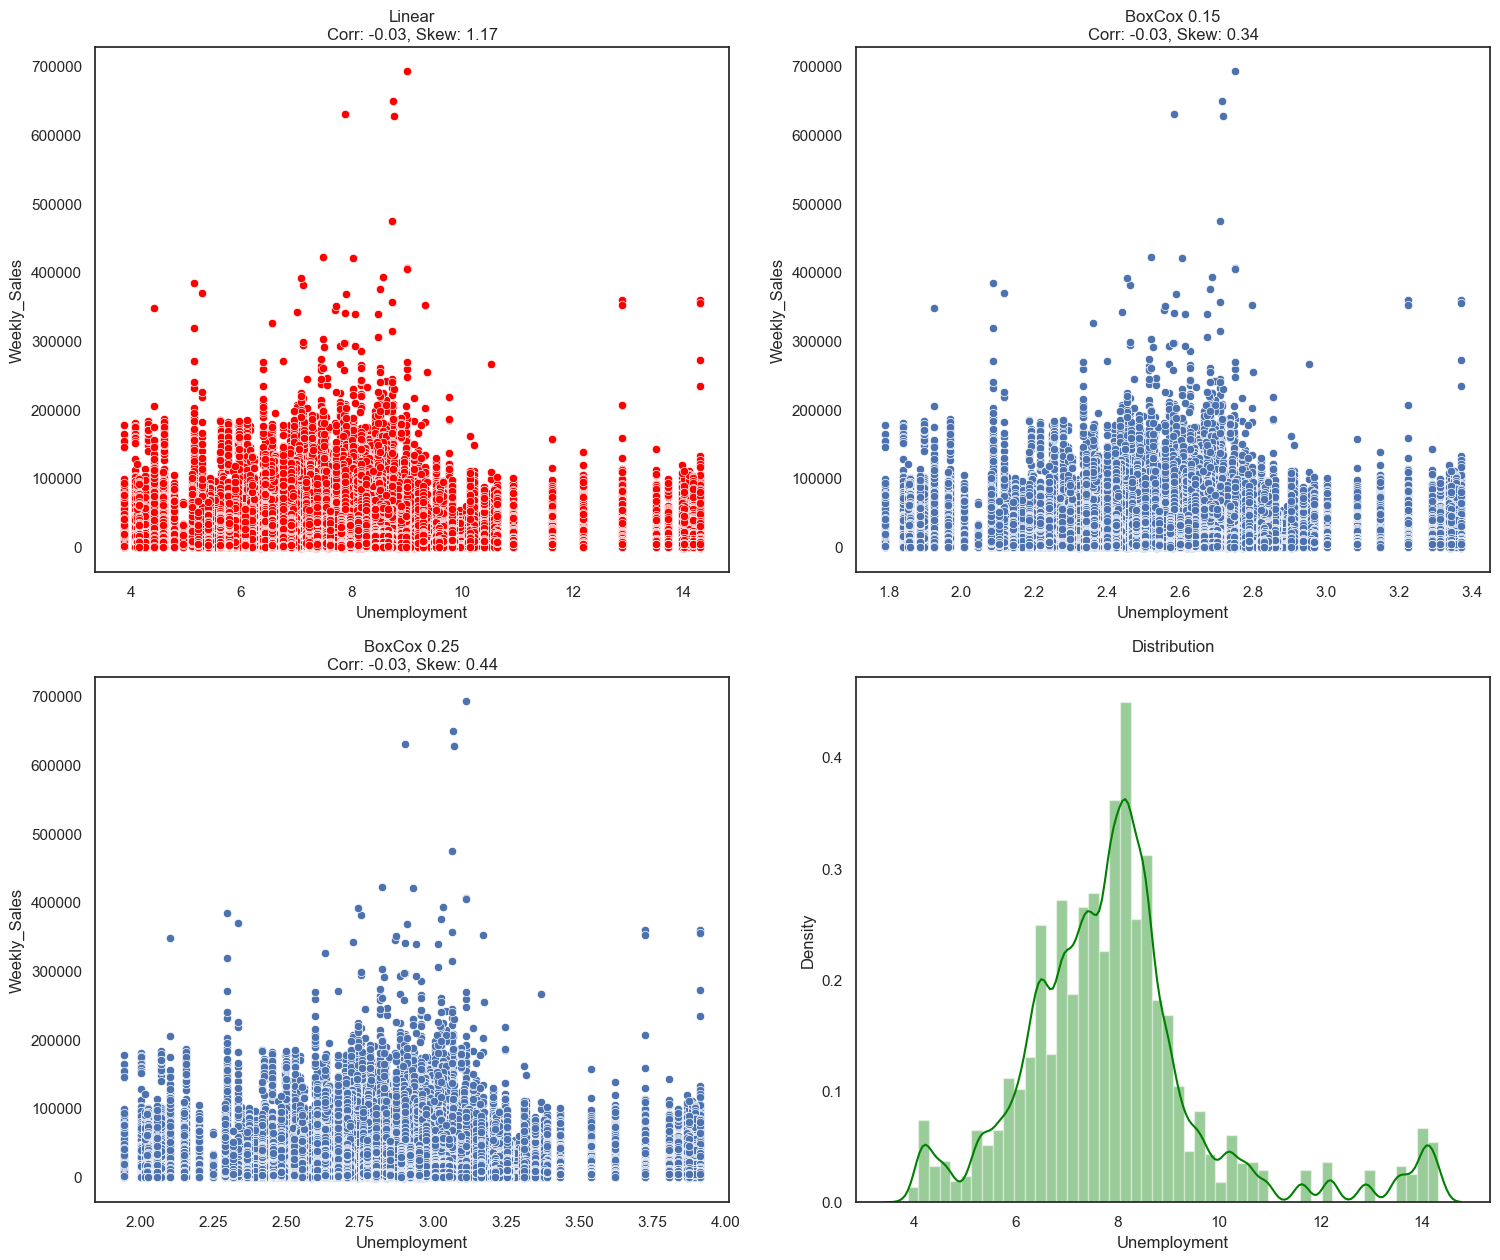

In [32]:
make_continuous_plot('Unemployment')

> Same for 'Unemployment' rate.

In [33]:
train_detail = train_detail.drop(columns=['Unemployment'])
test_detail = test_detail.drop(columns=['Unemployment'])

### Weekly_Sales x Size

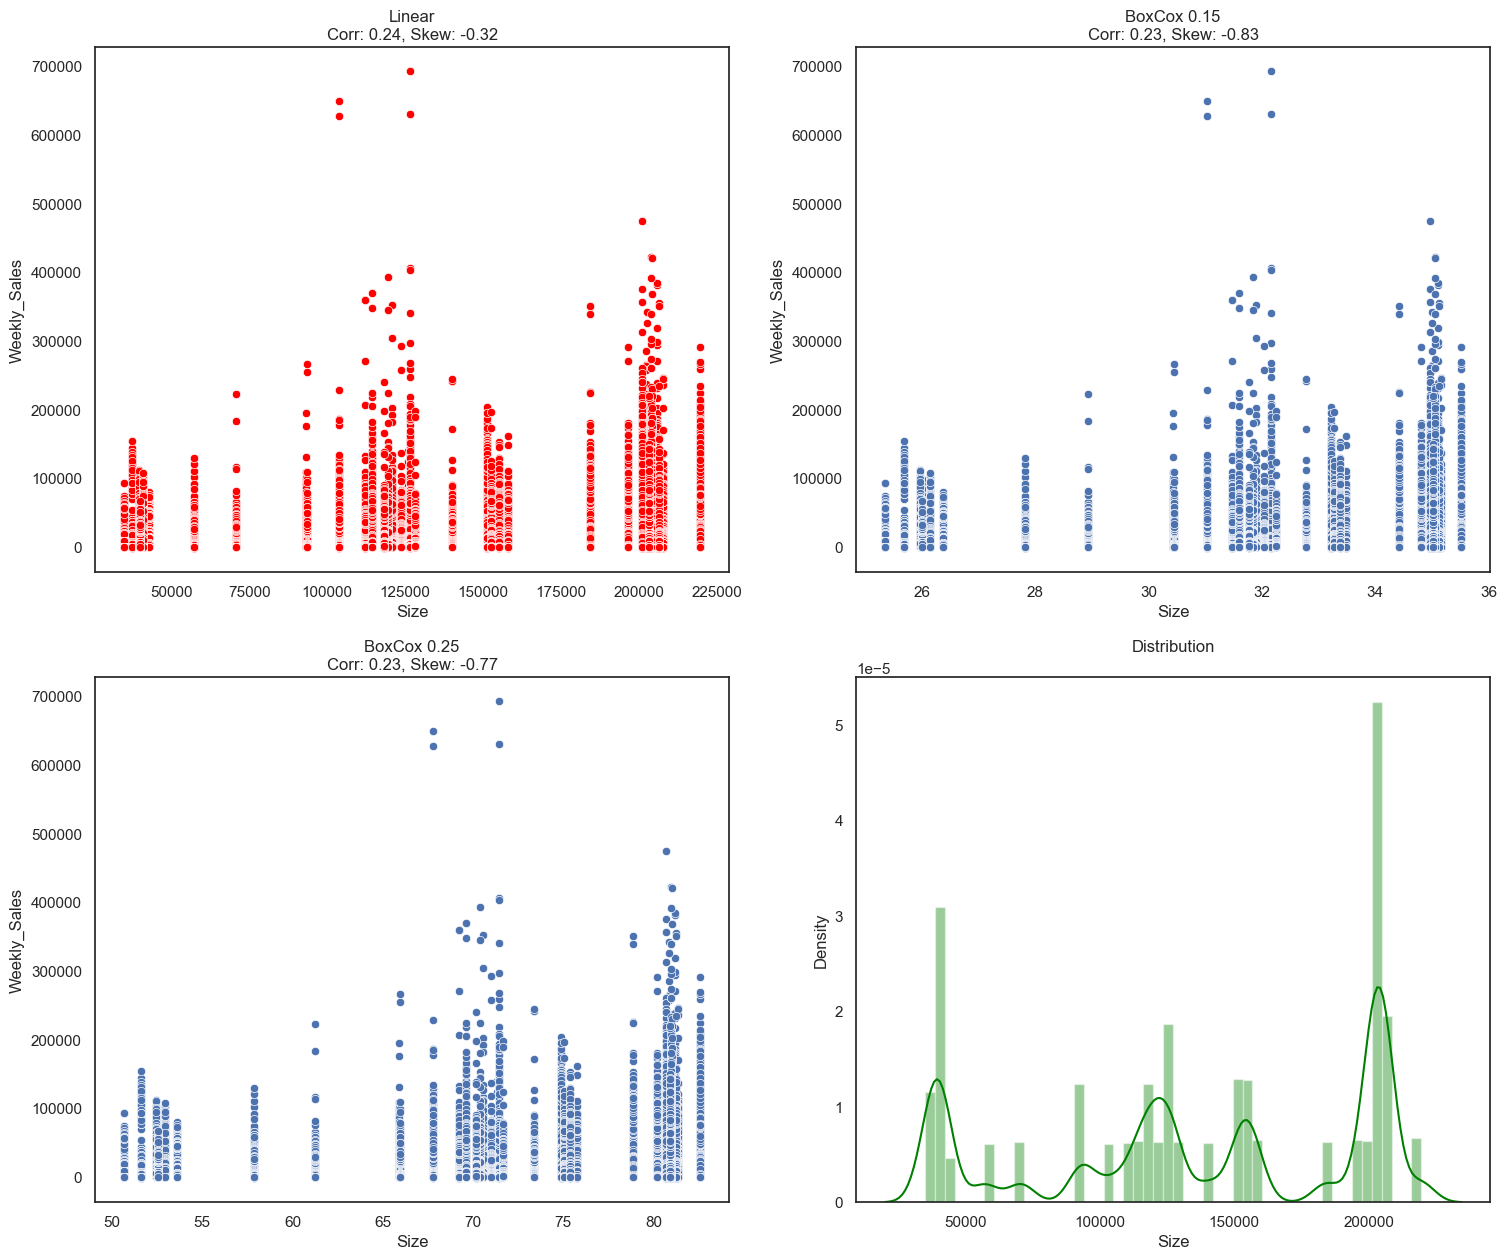

In [34]:
make_continuous_plot('Size')

> And, finally, we will continue with this variable, since it has moderate correlation with 'WeeklySales'.

### Machine Learning

### Model Functions

> As we can see in the figure below, the evaluation is based on Weighted Mean Absolute Error (WMAE), with a weight of 5 for Holiday Weeks and 1 otherwise.

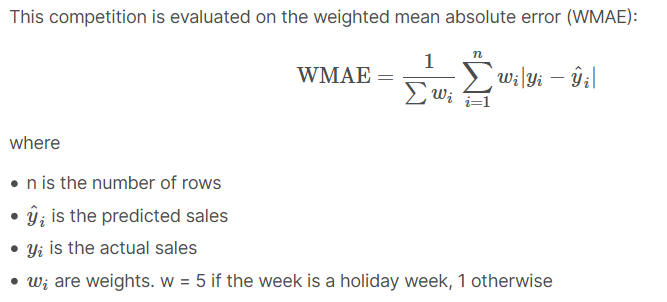

In [35]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

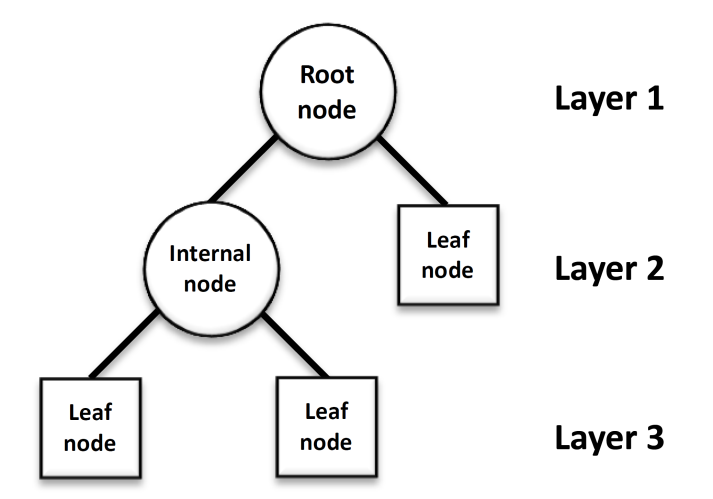

In [36]:
def random_forest(n_estimators, max_depth):
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [37]:
def random_forest_II(n_estimators, max_depth, max_features):
    result = []
    for feature in max_features:
        wmaes_cv = []
        for i in range(1,5):
            print('k:', i, ', max_features:', feature)
            x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
            RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=feature)
            RF.fit(x_train, y_train)
            predicted = RF.predict(x_test)
            wmaes_cv.append(WMAE(x_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))
        result.append({'Max_Feature': feature, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [38]:
def random_forest_III(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):
    result = []
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', min_samples_split:', split, ', min_samples_leaf:', leaf)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, 
                                           min_samples_leaf=leaf, min_samples_split=split)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Min_Samples_Leaf': leaf, 'Min_Samples_Split': split, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

### Training Model

> Preparing Train Set.

In [39]:
X_train = train_detail[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
Y_train = train_detail['Weekly_Sales']

> Tuning 'n_estimators' and 'max_depth'.

> Here, it is possible to test a lot of values. Those are the final ones, after a bit of testing.

In [40]:
n_estimators = [56, 58, 60]
max_depth = [25, 27, 30]

random_forest(n_estimators, max_depth)

k: 1 , n_estimators: 56 , max_depth: 25
k: 2 , n_estimators: 56 , max_depth: 25
k: 3 , n_estimators: 56 , max_depth: 25
k: 4 , n_estimators: 56 , max_depth: 25
WMAE: 1644.905
k: 1 , n_estimators: 56 , max_depth: 27
k: 2 , n_estimators: 56 , max_depth: 27
k: 3 , n_estimators: 56 , max_depth: 27
k: 4 , n_estimators: 56 , max_depth: 27
WMAE: 1662.9
k: 1 , n_estimators: 56 , max_depth: 30
k: 2 , n_estimators: 56 , max_depth: 30
k: 3 , n_estimators: 56 , max_depth: 30
k: 4 , n_estimators: 56 , max_depth: 30
WMAE: 1647.185
k: 1 , n_estimators: 58 , max_depth: 25
k: 2 , n_estimators: 58 , max_depth: 25
k: 3 , n_estimators: 58 , max_depth: 25
k: 4 , n_estimators: 58 , max_depth: 25
WMAE: 1639.995
k: 1 , n_estimators: 58 , max_depth: 27
k: 2 , n_estimators: 58 , max_depth: 27
k: 3 , n_estimators: 58 , max_depth: 27
k: 4 , n_estimators: 58 , max_depth: 27
WMAE: 1664.1725
k: 1 , n_estimators: 58 , max_depth: 30
k: 2 , n_estimators: 58 , max_depth: 30
k: 3 , n_estimators: 58 , max_depth: 30
k: 4 ,

,Max_Depth,Estimators,WMAE
0,25,56,1644.9050
1,27,56,1662.9000
2,30,56,1647.1850
3,25,58,1639.9950
4,27,58,1664.1725
5,30,58,1651.5400
6,25,60,1643.9175
7,27,60,1653.2900
8,30,60,1619.6425


Tuning 'max_features'.

In [41]:
max_features = [2, 3, 4, 5, 6, 7]

random_forest_II(n_estimators=58, max_depth=27, max_features=max_features)

k: 1 , max_features: 2
k: 2 , max_features: 2
k: 3 , max_features: 2
k: 4 , max_features: 2
WMAE: 4903.2775
k: 1 , max_features: 3
k: 2 , max_features: 3
k: 3 , max_features: 3
k: 4 , max_features: 3
WMAE: 2897.8975
k: 1 , max_features: 4
k: 2 , max_features: 4
k: 3 , max_features: 4
k: 4 , max_features: 4
WMAE: 1946.88
k: 1 , max_features: 5
k: 2 , max_features: 5
k: 3 , max_features: 5
k: 4 , max_features: 5
WMAE: 1660.825
k: 1 , max_features: 6
k: 2 , max_features: 6
k: 3 , max_features: 6
k: 4 , max_features: 6
WMAE: 1625.74
k: 1 , max_features: 7
k: 2 , max_features: 7
k: 3 , max_features: 7
k: 4 , max_features: 7
WMAE: 1658.87


,Max_Feature,WMAE
0,2,4903.2775
1,3,2897.8975
2,4,1946.8800
3,5,1660.8250
4,6,1625.7400
5,7,1658.8700


> Tuning 'min_samples_split' and 'min_samples_leaf'by their WMAE max

In [42]:
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3]

random_forest_III(n_estimators=58, max_depth=27, max_features=6, 
                  min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

k: 1 , min_samples_split: 2 , min_samples_leaf: 1
k: 2 , min_samples_split: 2 , min_samples_leaf: 1
k: 3 , min_samples_split: 2 , min_samples_leaf: 1
k: 4 , min_samples_split: 2 , min_samples_leaf: 1
WMAE: 1653.0674999999999
k: 1 , min_samples_split: 2 , min_samples_leaf: 2
k: 2 , min_samples_split: 2 , min_samples_leaf: 2
k: 3 , min_samples_split: 2 , min_samples_leaf: 2
k: 4 , min_samples_split: 2 , min_samples_leaf: 2
WMAE: 1733.0675
k: 1 , min_samples_split: 2 , min_samples_leaf: 3
k: 2 , min_samples_split: 2 , min_samples_leaf: 3
k: 3 , min_samples_split: 2 , min_samples_leaf: 3
k: 4 , min_samples_split: 2 , min_samples_leaf: 3
WMAE: 1752.8600000000001
k: 1 , min_samples_split: 3 , min_samples_leaf: 1
k: 2 , min_samples_split: 3 , min_samples_leaf: 1
k: 3 , min_samples_split: 3 , min_samples_leaf: 1
k: 4 , min_samples_split: 3 , min_samples_leaf: 1
WMAE: 1634.52
k: 1 , min_samples_split: 3 , min_samples_leaf: 2
k: 2 , min_samples_split: 3 , min_samples_leaf: 2
k: 3 , min_samples_s

,Min_Samples_Leaf,Min_Samples_Split,WMAE
0,1,2,1653.0675
1,2,2,1733.0675
2,3,2,1752.8600
3,1,3,1634.5200
4,2,3,1696.4900
5,3,3,1759.4200
6,1,4,1639.2675
7,2,4,1687.2600
8,3,4,1773.0350


> The final model:

In [43]:
RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=6, min_samples_split=3, min_samples_leaf=1)
RF.fit(X_train, Y_train)

RandomForestRegressor(max_depth=27, max_features=6, min_samples_split=3,
                      n_estimators=58)

### Predictions

In [44]:
X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
predict = RF.predict(X_test)

In [46]:
print(predict)

[19123.59708333 20289.14984647 21645.09039943 ...   710.30025862
   766.36651724   702.66456897]


#### Christmas Adjustment

> Let us make the Christmas Adjustment.

> We can remember that Christmas Week has 0 pre-holiday days in 2010, 1 in 2011 and 3 in 2012. So, it's a difference of 3 days from 2012 to 2010 and 2 days from 2012 to 2011. A 2.5 days average, in a week (7 days). So, this is the value that we are going to multiply to Week 51 and add to Week 52 to compensate what the model didn't take into account.

> But we are going to use this formula just for 'Stores'+'Departments' that have a big difference between Week 51 and Week 52 Sales. Let's say Week51 > 2 * Week52.

> Let's use another dataframe and SQL to solve it quickly.

In [47]:
Final = X_test[['Store', 'Dept', 'Week']]
Final['Weekly_Sales'] = predict

In [48]:
Final

,Store,Dept,Week,Weekly_Sales
0,1,1,46,19123.597083
1,1,1,47,20289.149846
2,1,1,48,21645.090399
3,1,1,50,45885.095078
4,1,1,51,50932.853353
...,...,...,...,...
67855,45,98,24,791.671825
67856,45,98,25,708.050994
67857,45,98,26,710.300259
67858,45,98,29,766.366517


In [49]:
Final['Weekly_Sales'] 

0        19123.597083
1        20289.149846
2        21645.090399
3        45885.095078
4        50932.853353
             ...     
67855      791.671825
67856      708.050994
67857      710.300259
67858      766.366517
67859      702.664569
Name: Weekly_Sales, Length: 67860, dtype: float64